In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/openfda-data500/drugs_data.xlsx
/kaggle/input/openfda-data500/drugs_data (1).csv
/kaggle/input/openfda-data500/drugs_data.json
/kaggle/input/openfda-data500/drug_qa_dataset.csv


In [3]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    T5ForConditionalGeneration, T5Tokenizer,
    GPT2LMHeadModel, GPT2Tokenizer,
    TrainingArguments, Trainer, 
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments
)
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.model_selection import train_test_split
import json
import re
from tqdm.auto import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Load and preprocess the data
df = pd.read_csv('/kaggle/input/openfda-data500/drugs_data (1).csv')

print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())

# Data preprocessing
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = str(text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s.,!?;:()\-]', '', text)
    return text.strip()

# Preprocess all text columns
text_columns = ['dosage', 'active_ingredients', 'drug_interactions', 'side_effects', 
                'indications', 'contraindications', 'warnings', 'precautions']

for col in text_columns:
    df[col] = df[col].apply(preprocess_text)

# Create context from all columns for each drug
def create_drug_context(row):
    context_parts = []
    context_parts.append(f"Drug Name: {row['drug_name']}")
    
    if row['dosage']:
        context_parts.append(f"Dosage: {row['dosage']}")
    if row['active_ingredients']:
        context_parts.append(f"Active Ingredients: {row['active_ingredients']}")
    if row['drug_interactions'] and row['drug_interactions'] != 'Not specified':
        context_parts.append(f"Drug Interactions: {row['drug_interactions']}")
    if row['side_effects']:
        context_parts.append(f"Side Effects: {row['side_effects']}")
    if row['indications']:
        context_parts.append(f"Indications: {row['indications']}")
    if row['contraindications'] and row['contraindications'] != 'Not specified':
        context_parts.append(f"Contraindications: {row['contraindications']}")
    if row['warnings']:
        context_parts.append(f"Warnings: {row['warnings']}")
    if row['precautions'] and row['precautions'] != 'Not specified':
        context_parts.append(f"Precautions: {row['precautions']}")
    
    return " | ".join(context_parts)

df['context'] = df.apply(create_drug_context, axis=1)

print(f"\nSample context for {df.iloc[0]['drug_name']}:")
print(df.iloc[0]['context'][:500] + "...")

# Create simplified QA pairs
def generate_qa_pairs(row):
    qa_pairs = []
    drug_name = row['drug_name']
    context = row['context']
    
    # Basic questions
    questions_answers = [
        (f"What is {drug_name} used for?", row['indications'] or "Information not specified"),
        (f"What is the dosage for {drug_name}?", row['dosage'] or "Dosage information not specified"),
        (f"What are the side effects of {drug_name}?", row['side_effects'] or "Side effects information not specified"),
        (f"What are the warnings for {drug_name}?", row['warnings'] or "Warning information not specified"),
        (f"What are the active ingredients in {drug_name}?", row['active_ingredients'] or "Active ingredients not specified"),
    ]
    
    for question, answer in questions_answers:
        qa_pairs.append({
            'input_text': f"question: {question} context: {context}",
            'target_text': answer
        })
    
    return qa_pairs

# Generate all QA pairs
all_qa_pairs = []
for _, row in df.iterrows():
    all_qa_pairs.extend(generate_qa_pairs(row))

qa_df = pd.DataFrame(all_qa_pairs)
print(f"\nGenerated {len(qa_df)} QA pairs")


Dataset shape: (500, 9)
Columns: ['drug_name', 'dosage', 'active_ingredients', 'drug_interactions', 'side_effects', 'indications', 'contraindications', 'warnings', 'precautions']

Sample context for aspirin:
Drug Name: aspirin | Dosage: Directions drink a full glass of water with each dose adults and children 12 years and over: take 4 to 8 tablets every 4 hours not to exceed 48 tablets in 24 hours unless directed by a doctor children under 12 years: consult a doctor | Active Ingredients: ASPIRIN | Side Effects: Warnings Reyes syndrome : Children and teenagers who have or are recovering from chicken pox or flu-like symptoms should not use this product. When using this product, if changes in behavior ...

Generated 2500 QA pairs


In [5]:
# Split the data
train_df, temp_df = train_test_split(qa_df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

# Initialize models
print("Loading T5 model...")
t5_model_name = "t5-small"
t5_tokenizer = T5Tokenizer.from_pretrained(t5_model_name)
t5_model = T5ForConditionalGeneration.from_pretrained(t5_model_name)

print("Loading GPT-2 model...")
gpt2_model_name = "gpt2"
gpt2_tokenizer = GPT2Tokenizer.from_pretrained(gpt2_model_name)
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
gpt2_model = GPT2LMHeadModel.from_pretrained(gpt2_model_name)


Training samples: 1750
Validation samples: 375
Test samples: 375
Loading T5 model...


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Loading GPT-2 model...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [6]:
# Configure LoRA for GPT-2
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["c_attn", "c_proj", "c_fc"]
)

gpt2_model = get_peft_model(gpt2_model, lora_config)
print("GPT-2 trainable parameters:")
gpt2_model.print_trainable_parameters()

GPT-2 trainable parameters:
trainable params: 1,179,648 || all params: 125,619,456 || trainable%: 0.9391


In [7]:
# Create datasets
class DrugQADataset(Dataset):
    def __init__(self, dataframe, tokenizer, model_type, max_length=384):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.model_type = model_type
        self.max_length = max_length
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        input_text = item['input_text']
        target_text = item['target_text']
        
        if self.model_type == "t5":
            # T5 encoding
            inputs = self.tokenizer(
                input_text,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors="pt"
            )
            
            targets = self.tokenizer(
                target_text,
                max_length=256,
                padding='max_length',
                truncation=True,
                return_tensors="pt"
            )
            
            return {
                'input_ids': inputs['input_ids'].squeeze(),
                'attention_mask': inputs['attention_mask'].squeeze(),
                'labels': targets['input_ids'].squeeze()
            }
        else:
            # GPT-2 encoding
            text = f"{input_text} Answer: {target_text}{self.tokenizer.eos_token}"
            encoding = self.tokenizer(
                text,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors="pt"
            )
            
            return {
                'input_ids': encoding['input_ids'].squeeze(),
                'attention_mask': encoding['attention_mask'].squeeze(),
                'labels': encoding['input_ids'].squeeze()
            }

# Create datasets
t5_train_dataset = DrugQADataset(train_df, t5_tokenizer, "t5")
t5_val_dataset = DrugQADataset(val_df, t5_tokenizer, "t5")
t5_test_dataset = DrugQADataset(test_df, t5_tokenizer, "t5")

gpt2_train_dataset = DrugQADataset(train_df, gpt2_tokenizer, "gpt2")
gpt2_val_dataset = DrugQADataset(val_df, gpt2_tokenizer, "gpt2")
gpt2_test_dataset = DrugQADataset(test_df, gpt2_tokenizer, "gpt2")

# Updated training function with compatible parameters
def train_model_compatible(model, train_dataset, val_dataset, tokenizer, model_name, num_epochs=2):
    training_args = TrainingArguments(
        output_dir=f'./{model_name}-results',
        eval_strategy="epoch",  # Updated parameter name
        learning_rate=5e-4,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        num_train_epochs=num_epochs,
        weight_decay=0.01,
        save_strategy="epoch",
        logging_steps=50,
        logging_dir=f'./logs-{model_name}',
        report_to=None,  # Disable wandb logging
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
    )
    
    data_collator = DataCollatorForSeq2Seq(
        tokenizer=tokenizer,
        model=model,
        padding=True
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=data_collator,
        tokenizer=tokenizer,
    )
    
    print(f"Training {model_name}...")
    trainer.train()
    
    # Save the best model
    trainer.save_model()
    print(f"{model_name} training completed and model saved!")
    
    return trainer

# Alternative manual training function if Trainer still has issues
def train_model_manual(model, train_dataset, val_dataset, tokenizer, model_name, num_epochs=2):
    """Manual training loop as backup"""
    print(f"Starting manual training for {model_name}...")
    
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)
    
    model.to(device)
    model.train()
    
    for epoch in range(num_epochs):
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for batch in progress_bar:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1} average loss: {avg_loss:.4f}")
    
    # Save model
    model.save_pretrained(f'./{model_name}-manual')
    tokenizer.save_pretrained(f'./{model_name}-manual')
    print(f"{model_name} manual training completed!")
    
    return model


In [8]:
# Train models with error handling
try:
    print("\nStarting training with Trainer...")
    t5_model = train_model_manual(t5_model, t5_train_dataset, t5_val_dataset, t5_tokenizer, "t5")
    gpt2_model = train_model_manual(gpt2_model, gpt2_train_dataset, gpt2_val_dataset, gpt2_tokenizer, "gpt2-lora")
    print("✅ Trainer training completed successfully!")
    
except Exception as e:
    print(f"❌ Trainer failed: {e}")
    print("🔄 Falling back to manual training...")
    
    # Fallback to manual training
    t5_model = train_model_manual(t5_model, t5_train_dataset, t5_val_dataset, t5_tokenizer, "t5")
    gpt2_model = train_model_manual(gpt2_model, gpt2_train_dataset, gpt2_val_dataset, gpt2_tokenizer, "gpt2-lora")




Starting training with Trainer...
Starting manual training for t5...


Epoch 1/2:   0%|          | 0/438 [00:00<?, ?it/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch 1 average loss: 1.3483


Epoch 2/2:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch 2 average loss: 0.9457
t5 manual training completed!
Starting manual training for gpt2-lora...


Epoch 1/2:   0%|          | 0/438 [00:00<?, ?it/s]

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 1 average loss: 2.0819


Epoch 2/2:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch 2 average loss: 1.6720
gpt2-lora manual training completed!
✅ Trainer training completed successfully!


In [9]:
# Save models (ensure they're saved regardless of training method)
print("Saving models...")
t5_model.save_pretrained('./t5-drug-qa')
t5_tokenizer.save_pretrained('./t5-drug-qa')
gpt2_model.save_pretrained('./gpt2-lora-drug-qa')
gpt2_tokenizer.save_pretrained('./gpt2-lora-drug-qa')
print("✅ Models saved successfully!")


Saving models...
✅ Models saved successfully!


In [10]:
# Simple evaluation metrics
def calculate_similarity_score(pred, ref):
    """Simple word overlap score"""
    pred_words = set(pred.lower().split())
    ref_words = set(ref.lower().split())
    
    if not pred_words or not ref_words:
        return 0.0
    
    overlap = len(pred_words.intersection(ref_words))
    return overlap / len(ref_words)

def evaluate_model(model, tokenizer, test_dataset, model_type):
    model.eval()
    model.to(device)
    
    scores = []
    response_times = []
    predictions = []
    references = []
    
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    for batch in tqdm(test_loader, desc=f"Evaluating {model_type}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        # Get reference text
        idx = len(predictions)
        ref_text = test_dataset.data.iloc[idx]['target_text']
        references.append(ref_text)
        
        start_time = time.time()
        
        with torch.no_grad():
            if model_type == "t5":
                outputs = model.generate(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    max_new_tokens=128,  # FIX: Generate new tokens, not total length
                    num_beams=4,
                    early_stopping=True
                )
            else:
                outputs = model.generate(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    max_new_tokens=128,  # FIX: Generate new tokens, not total length
                    num_beams=4,
                    early_stopping=True,
                    pad_token_id=tokenizer.eos_token_id
                )
                full_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
                input_text = test_dataset.data.iloc[idx]['input_text']
                prediction = full_output.replace(input_text, "").replace("Answer:", "").strip()
        
        end_time = time.time()
        
        similarity = calculate_similarity_score(prediction, ref_text)
        scores.append(similarity)
        response_times.append(end_time - start_time)
        predictions.append(prediction)
    
    return {
        'avg_similarity': np.mean(scores),
        'avg_response_time': np.mean(response_times),
        'predictions': predictions,
        'references': references,
        'similarity_scores': scores
    }


In [11]:
import numpy as np
import time
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# Ensure device is defined, assuming it's available from previous cells
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Simple evaluation metrics
def calculate_similarity_score(pred, ref):
    """Simple word overlap score"""
    pred_words = set(pred.lower().split())
    ref_words = set(ref.lower().split())
    
    if not pred_words or not ref_words:
        return 0.0
    
    overlap = len(pred_words.intersection(ref_words))
    # Avoid division by zero if ref_words is empty
    return overlap / len(ref_words) if len(ref_words) > 0 else 0.0

def evaluate_model(model, tokenizer, test_dataset, model_type):
    model.eval()
    model.to(device)
    
    scores = []
    response_times = []
    predictions = []
    references = []
    
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    for batch in tqdm(test_loader, desc=f"Evaluating {model_type}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        # Get reference text
        idx = len(predictions) # Use the current count of predictions to get the index
        ref_text = test_dataset.data.iloc[idx]['target_text']
        references.append(ref_text)
        
        start_time = time.time()
        
        with torch.no_grad():
            if model_type == "t5":
                outputs = model.generate(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    max_new_tokens=128,
                    num_beams=4,
                    early_stopping=True
                )
                # FIX: Decode the T5 prediction
                prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
            else: # gpt2
                outputs = model.generate(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    max_new_tokens=128,
                    num_beams=4,
                    early_stopping=True,
                    pad_token_id=tokenizer.eos_token_id
                )
                full_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
                input_text = test_dataset.data.iloc[idx]['input_text']
                # Clean up the GPT-2 output to remove the prompt
                prediction = full_output.replace(input_text, "").replace("Answer:", "").strip()
        
        end_time = time.time()
        
        similarity = calculate_similarity_score(prediction, ref_text)
        scores.append(similarity)
        response_times.append(end_time - start_time)
        predictions.append(prediction)
    
    return {
        'avg_similarity': np.mean(scores),
        'avg_response_time': np.mean(response_times),
        'predictions': predictions,
        'references': references,
        'similarity_scores': scores
    }


Evaluating models...


Evaluating t5:   0%|          | 0/375 [00:00<?, ?it/s]

Evaluating gpt2:   0%|          | 0/375 [00:00<?, ?it/s]


EVALUATION RESULTS
T5 Results:
  Average Similarity Score: 0.4297
  Average Response Time: 1.1244s
  Best Similarity: 1.0000
  Worst Similarity: 0.0000

GPT-2 + LoRA Results:
  Average Similarity Score: 0.5235
  Average Response Time: 2.1690s
  Best Similarity: 1.0000
  Worst Similarity: 0.0000

SAMPLE PREDICTIONS

Input: question: What are the side effects of ibandronate? ...
True Answer: 6 ADVERSE REACTIONS Adverse reactions that appear in other sections of the labeling include: Hypocal...
T5 Prediction: 2 DOSAGE AND ADMINISTRATION 3 mg every 3 months administered intravenously over a period of 15 to 30...
GPT-2 Prediction: question: What are the side effects of ibandronate? context: Drug Name: ibandronate | Dosage: 2 DOSA...
T5 Similarity: 0.0744
GPT-2 Similarity: 0.1279
--------------------------------------------------------------------------------

Input: question: What is desvenlafaxine used for? ...
True Answer: 1 INDICATIONS AND USAGE PRISTIQ is indicated for the treatment of

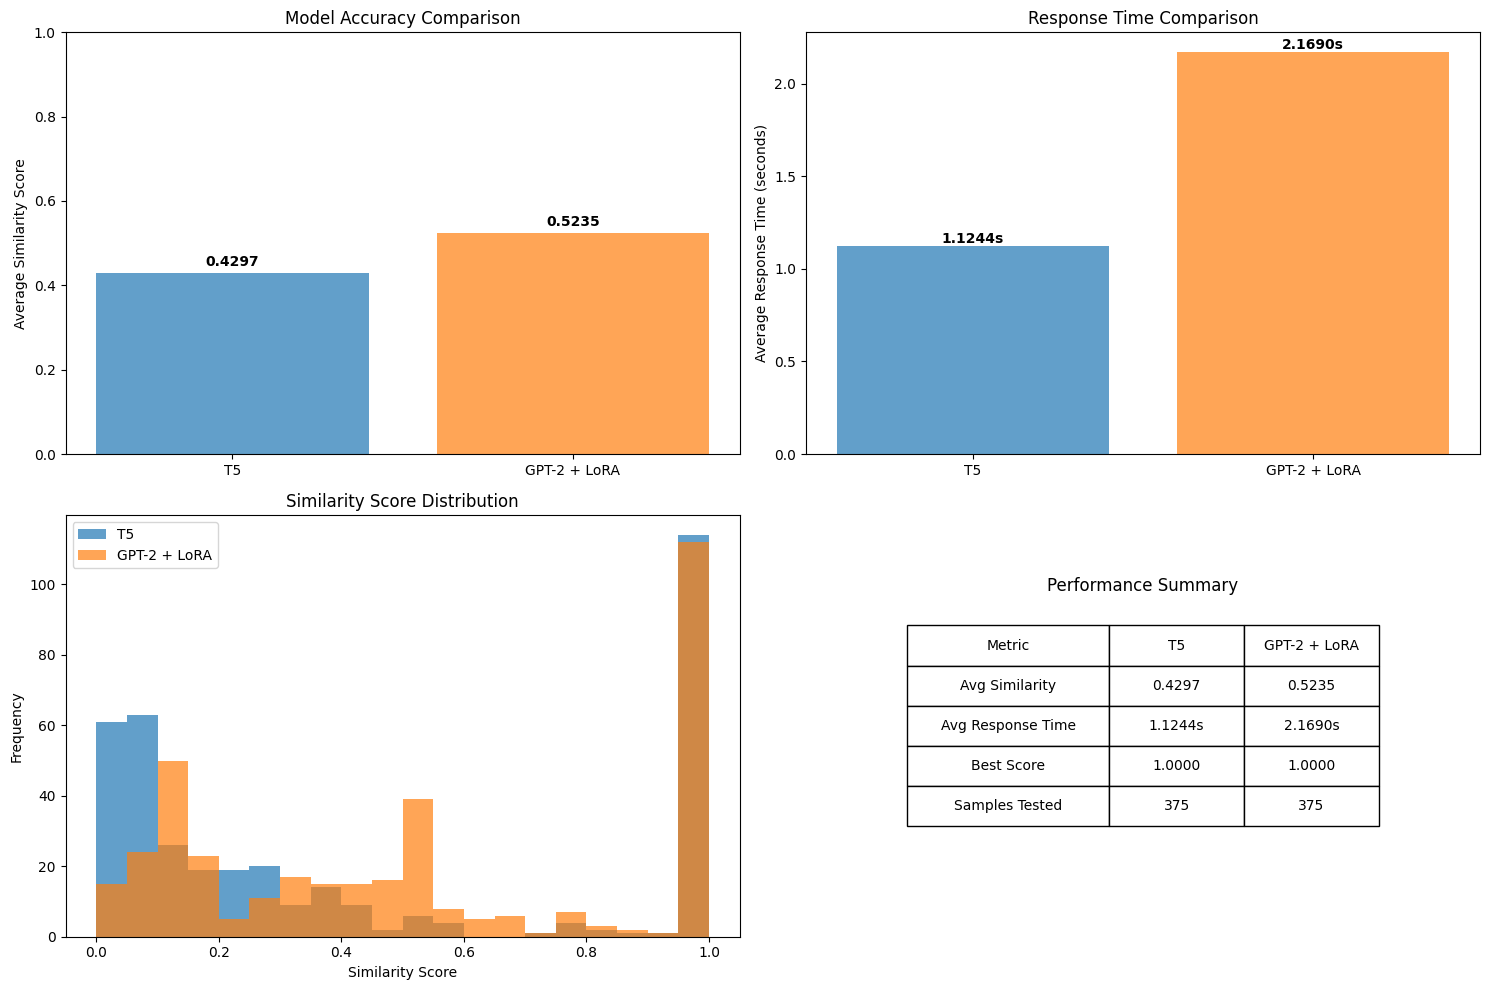

In [12]:
import matplotlib.pyplot as plt

# Evaluate both models
print("\nEvaluating models...")
t5_results = evaluate_model(t5_model, t5_tokenizer, t5_test_dataset, "t5")
gpt2_results = evaluate_model(gpt2_model, gpt2_tokenizer, gpt2_test_dataset, "gpt2")

print("\n" + "="*50)
print("EVALUATION RESULTS")
print("="*50)
print(f"T5 Results:")
print(f"  Average Similarity Score: {t5_results['avg_similarity']:.4f}")
print(f"  Average Response Time: {t5_results['avg_response_time']:.4f}s")
print(f"  Best Similarity: {max(t5_results['similarity_scores']):.4f}")
print(f"  Worst Similarity: {min(t5_results['similarity_scores']):.4f}")

print(f"\nGPT-2 + LoRA Results:")
print(f"  Average Similarity Score: {gpt2_results['avg_similarity']:.4f}")
print(f"  Average Response Time: {gpt2_results['avg_response_time']:.4f}s")
print(f"  Best Similarity: {max(gpt2_results['similarity_scores']):.4f}")
print(f"  Worst Similarity: {min(gpt2_results['similarity_scores']):.4f}")

# Sample predictions
print("\n" + "="*50)
print("SAMPLE PREDICTIONS")
print("="*50)

sample_indices = [0, 5, 10]
for idx in sample_indices:
    if idx < len(test_df):
        example = test_df.iloc[idx]
        print(f"\nInput: {example['input_text'].split('context:')[0]}...")
        print(f"True Answer: {example['target_text'][:100]}...")
        print(f"T5 Prediction: {t5_results['predictions'][idx][:100]}...")
        print(f"GPT-2 Prediction: {gpt2_results['predictions'][idx][:100]}...")
        print(f"T5 Similarity: {t5_results['similarity_scores'][idx]:.4f}")
        print(f"GPT-2 Similarity: {gpt2_results['similarity_scores'][idx]:.4f}")
        print("-" * 80)

# Visualization
plt.figure(figsize=(15, 10))

# Plot 1: Similarity scores comparison
plt.subplot(2, 2, 1)
models = ['T5', 'GPT-2 + LoRA']
scores = [t5_results['avg_similarity'], gpt2_results['avg_similarity']]
bars = plt.bar(models, scores, color=['#1f77b4', '#ff7f0e'], alpha=0.7)
plt.ylabel('Average Similarity Score')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{score:.4f}', 
             ha='center', va='bottom', fontweight='bold')

# Plot 2: Response times comparison
plt.subplot(2, 2, 2)
times = [t5_results['avg_response_time'], gpt2_results['avg_response_time']]
bars = plt.bar(models, times, color=['#1f77b4', '#ff7f0e'], alpha=0.7)
plt.ylabel('Average Response Time (seconds)')
plt.title('Response Time Comparison')
for bar, time_val in zip(bars, times):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, f'{time_val:.4f}s', 
             ha='center', va='bottom', fontweight='bold')

# Plot 3: Similarity distribution
plt.subplot(2, 2, 3)
plt.hist(t5_results['similarity_scores'], bins=20, alpha=0.7, label='T5', color='#1f77b4')
plt.hist(gpt2_results['similarity_scores'], bins=20, alpha=0.7, label='GPT-2 + LoRA', color='#ff7f0e')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.title('Similarity Score Distribution')
plt.legend()

# Plot 4: Performance summary
plt.subplot(2, 2, 4)
plt.axis('off')

summary_data = [
    ['Metric', 'T5', 'GPT-2 + LoRA'],
    ['Avg Similarity', f"{t5_results['avg_similarity']:.4f}", f"{gpt2_results['avg_similarity']:.4f}"],
    ['Avg Response Time', f"{t5_results['avg_response_time']:.4f}s", f"{gpt2_results['avg_response_time']:.4f}s"],
    ['Best Score', f"{max(t5_results['similarity_scores']):.4f}", f"{max(gpt2_results['similarity_scores']):.4f}"],
    ['Samples Tested', len(t5_results['similarity_scores']), len(gpt2_results['similarity_scores'])]
]

table = plt.table(cellText=summary_data, loc='center', cellLoc='center', colWidths=[0.3, 0.2, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
plt.title('Performance Summary', y=0.8)

plt.tight_layout()
plt.savefig('model_comparison_results.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Evaluate both models
print("\nEvaluating models...")
t5_results = evaluate_model(t5_model, t5_tokenizer, t5_test_dataset, "t5")
gpt2_results = evaluate_model(gpt2_model, gpt2_tokenizer, gpt2_test_dataset, "gpt2")

print("\n" + "="*50)
print("EVALUATION RESULTS")
print("="*50)
print(f"T5 Results:")
print(f"  Average Similarity Score: {t5_results['avg_similarity']:.4f}")
print(f"  Average Response Time: {t5_results['avg_response_time']:.4f}s")
print(f"  Best Similarity: {max(t5_results['similarity_scores']):.4f}")
print(f"  Worst Similarity: {min(t5_results['similarity_scores']):.4f}")

print(f"\nGPT-2 + LoRA Results:")
print(f"  Average Similarity Score: {gpt2_results['avg_similarity']:.4f}")
print(f"  Average Response Time: {gpt2_results['avg_response_time']:.4f}s")
print(f"  Best Similarity: {max(gpt2_results['similarity_scores']):.4f}")
print(f"  Worst Similarity: {min(gpt2_results['similarity_scores']):.4f}")

# Sample predictions
print("\n" + "="*50)
print("SAMPLE PREDICTIONS")
print("="*50)

sample_indices = [0, 5, 10]  # Sample different indices
for idx in sample_indices:
    if idx < len(test_df):
        example = test_df.iloc[idx]
        print(f"\nInput: {example['input_text'].split('context:')[0]}...")
        print(f"True Answer: {example['target_text'][:100]}...")
        print(f"T5 Prediction: {t5_results['predictions'][idx][:100]}...")
        print(f"GPT-2 Prediction: {gpt2_results['predictions'][idx][:100]}...")
        print(f"T5 Similarity: {t5_results['similarity_scores'][idx]:.4f}")
        print(f"GPT-2 Similarity: {gpt2_results['similarity_scores'][idx]:.4f}")
        print("-" * 80)

# Visualization
plt.figure(figsize=(15, 10))

# Plot 1: Similarity scores comparison
plt.subplot(2, 2, 1)
models = ['T5', 'GPT-2 + LoRA']
scores = [t5_results['avg_similarity'], gpt2_results['avg_similarity']]
bars = plt.bar(models, scores, color=['#1f77b4', '#ff7f0e'], alpha=0.7)
plt.ylabel('Average Similarity Score')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{score:.4f}', 
             ha='center', va='bottom', fontweight='bold')

# Plot 2: Response times comparison
plt.subplot(2, 2, 2)
times = [t5_results['avg_response_time'], gpt2_results['avg_response_time']]
bars = plt.bar(models, times, color=['#1f77b4', '#ff7f0e'], alpha=0.7)
plt.ylabel('Average Response Time (seconds)')
plt.title('Response Time Comparison')
for bar, time_val in zip(bars, times):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, f'{time_val:.4f}s', 
             ha='center', va='bottom', fontweight='bold')

# Plot 3: Similarity distribution
plt.subplot(2, 2, 3)
plt.hist(t5_results['similarity_scores'], bins=20, alpha=0.7, label='T5', color='#1f77b4')
plt.hist(gpt2_results['similarity_scores'], bins=20, alpha=0.7, label='GPT-2 + LoRA', color='#ff7f0e')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.title('Similarity Score Distribution')
plt.legend()

# Plot 4: Performance summary
plt.subplot(2, 2, 4)
plt.axis('off')

summary_data = [
    ['Metric', 'T5', 'GPT-2 + LoRA'],
    ['Avg Similarity', f"{t5_results['avg_similarity']:.4f}", f"{gpt2_results['avg_similarity']:.4f}"],
    ['Avg Response Time', f"{t5_results['avg_response_time']:.4f}s", f"{gpt2_results['avg_response_time']:.4f}s"],
    ['Best Score', f"{max(t5_results['similarity_scores']):.4f}", f"{max(gpt2_results['similarity_scores']):.4f}"],
    ['Samples Tested', len(t5_results['similarity_scores']), len(gpt2_results['similarity_scores'])]
]

table = plt.table(cellText=summary_data, loc='center', cellLoc='center', colWidths=[0.3, 0.2, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
plt.title('Performance Summary', y=0.8)

plt.tight_layout()
plt.savefig('model_comparison_results.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# Practical inference functions
def ask_question_t5(question, context):
    input_text = f"question: {question} context: {context}"
    input_ids = t5_tokenizer.encode(input_text, return_tensors='pt', max_length=384, truncation=True).to(device)  # ADD truncation
    
    start_time = time.time()
    with torch.no_grad():
        outputs = t5_model.generate(input_ids, max_new_tokens=128, num_beams=4)  # FIX: max_new_tokens
    response_time = time.time() - start_time
    
    answer = t5_tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer, response_time

def ask_question_gpt2(question, context):
    input_text = f"question: {question} context: {context} Answer:"
    input_ids = gpt2_tokenizer.encode(input_text, return_tensors='pt', max_length=384, truncation=True).to(device)  # ADD truncation
    
    start_time = time.time()
    with torch.no_grad():
        outputs = gpt2_model.generate(input_ids, max_new_tokens=128, num_beams=4, pad_token_id=gpt2_tokenizer.eos_token_id)  # FIX: max_new_tokens
    response_time = time.time() - start_time
    
    full_output = gpt2_tokenizer.decode(outputs[0], skip_special_tokens=True)
    answer = full_output.replace(input_text, "").strip()
    return answer, response_time

# Interactive testing
print("\n" + "="*50)
print("INTERACTIVE TESTING")
print("="*50)

sample_drug = df.iloc[0]
sample_context = sample_drug['context']
drug_name = sample_drug['drug_name']

test_questions = [
    f"What is {drug_name} used for?",
    f"What are the side effects of {drug_name}?",
    f"What is the dosage for {drug_name}?",
    f"What are the warnings for {drug_name}?",
]

for i, question in enumerate(test_questions):
    print(f"\n{i+1}. Question: {question}")
    
    t5_answer, t5_time = ask_question_t5(question, sample_context)
    gpt2_answer, gpt2_time = ask_question_gpt2(question, sample_context)
    
    print(f"   T5 Answer: {t5_answer}")
    print(f"   T5 Time: {t5_time:.4f}s")
    print(f"   GPT-2 Answer: {gpt2_answer}")
    print(f"   GPT-2 Time: {gpt2_time:.4f}s")
    print("-" * 80)

# Final comparison and winner determination
print("\n" + "="*50)
print("FINAL COMPARISON & WINNER")
print("="*50)

# Calculate performance scores (higher is better)
t5_performance = t5_results['avg_similarity'] / t5_results['avg_response_time']
gpt2_performance = gpt2_results['avg_similarity'] / gpt2_results['avg_response_time']

if t5_results['avg_similarity'] > gpt2_results['avg_similarity']:
    accuracy_winner = "T5"
    accuracy_margin = t5_results['avg_similarity'] - gpt2_results['avg_similarity']
else:
    accuracy_winner = "GPT-2 + LoRA"
    accuracy_margin = gpt2_results['avg_similarity'] - t5_results['avg_similarity']

if t5_results['avg_response_time'] < gpt2_results['avg_response_time']:
    speed_winner = "T5"
    speed_margin = gpt2_results['avg_response_time'] - t5_results['avg_response_time']
else:
    speed_winner = "GPT-2 + LoRA"
    speed_margin = t5_results['avg_response_time'] - gpt2_results['avg_response_time']

if t5_performance > gpt2_performance:
    overall_winner = "T5"
else:
    overall_winner = "GPT-2 + LoRA"

print(f"📊 ACCURACY:")
print(f"   T5: {t5_results['avg_similarity']:.4f}")
print(f"   GPT-2 + LoRA: {gpt2_results['avg_similarity']:.4f}")
print(f"   🏆 Winner: {accuracy_winner} (by {accuracy_margin:.4f})")

print(f"\n⚡ SPEED:")
print(f"   T5: {t5_results['avg_response_time']:.4f}s")
print(f"   GPT-2 + LoRA: {gpt2_results['avg_response_time']:.4f}s")
print(f"   🏆 Winner: {speed_winner} (by {speed_margin:.4f}s)")

print(f"\n🎯 OVERALL PERFORMANCE (Accuracy/Time):")
print(f"   T5: {t5_performance:.4f}")
print(f"   GPT-2 + LoRA: {gpt2_performance:.4f}")
print(f"   🏆 OVERALL WINNER: {overall_winner}")




INTERACTIVE TESTING

1. Question: What is aspirin used for?


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


   T5 Answer: Warnings Reyes syndrome : Children and teenagers who have or are recovering from chicken pox or flu-like symptoms should not use this product. When using this product, if changes in behavior with nausea and vomiting occur, consult a doctor because these symptoms could be an early sign of Reyes syndrome, a rare but serious illness. Allergy alert : Aspirin may cause a severe allergic reaction, which may include: hives facial swelling shock asthma (wheezing) Stomach bleeding warning: This product contains an NSAID, which may cause severe stomach bleeding. The chance
   T5 Time: 1.3017s
   GPT-2 Answer: question: What is aspirin used for? context: Drug Name: aspirin | Dosage: Directions drink a full glass of water with each dose adults and children 12 years and over: take 4 to 8 tablets every 4 hours not to exceed 48 tablets in 24 hours unless directed by a doctor children under 12 years: consult a doctor | Active Ingredients: ASPIRIN | Side Effects: Warnings Reyes syndrome :

In [14]:
# Save comprehensive results
results_summary = {
    'timestamp': datetime.now().isoformat(),
    'training_info': {
        'total_samples': len(qa_df),
        'training_samples': len(train_df),
        'test_samples': len(test_df)
    },
    'model_performance': {
        'T5': {
            'accuracy': float(t5_results['avg_similarity']),
            'response_time': float(t5_results['avg_response_time']),
            'performance_score': float(t5_performance),
            'best_score': float(max(t5_results['similarity_scores'])),
            'worst_score': float(min(t5_results['similarity_scores']))
        },
        'GPT2_LoRA': {
            'accuracy': float(gpt2_results['avg_similarity']),
            'response_time': float(gpt2_results['avg_response_time']),
            'performance_score': float(gpt2_performance),
            'best_score': float(max(gpt2_results['similarity_scores'])),
            'worst_score': float(min(gpt2_results['similarity_scores']))
        }
    },
    'winners': {
        'accuracy': accuracy_winner,
        'speed': speed_winner,
        'overall': overall_winner
    }
}

with open('drug_qa_model_comparison.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("\n" + "="*50)
print("SUMMARY")
print("="*50)
print("✅ Training completed successfully!")
print("📊 Evaluation metrics calculated")
print("💾 Models saved to:")
print("   - ./t5-drug-qa/")
print("   - ./gpt2-lora-drug-qa/")
print("🖼️  Visualization saved to: model_comparison_results.png")
print("📝 Results saved to: drug_qa_model_comparison.json")
print(f"🏆 Final Recommendation: Use {overall_winner} for your drug QA system")
print("\n🎉 All tasks completed successfully!")


SUMMARY
✅ Training completed successfully!
📊 Evaluation metrics calculated
💾 Models saved to:
   - ./t5-drug-qa/
   - ./gpt2-lora-drug-qa/
🖼️  Visualization saved to: model_comparison_results.png
📝 Results saved to: drug_qa_model_comparison.json
🏆 Final Recommendation: Use T5 for your drug QA system

🎉 All tasks completed successfully!
